# Strategy composite
A composite backtesting sample that allow to run a strategy based on equities of other strategies, i.e. creating meta-strategy

In [2]:
import pandas as pd
import numpy as np

In [3]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [5]:
from yauber_backtester import Asset, Backtester, Strategy, Account, Report, MFrame

# Create 100 random assets

In [6]:
def make_rnd_asset(name):
    dt_index = pd.date_range('2010-01-01', '2018-01-01')
    ser = pd.Series(np.random.normal(size=len(dt_index)), index=dt_index).cumsum()
    asset_dict = {
            'ticker': f'RND_{name}',
            'quotes': pd.DataFrame({
                'o': ser,
                'h': ser,
                'l': ser,
                'c': ser,
                'exec': ser.shift(-1),
            }, index=ser.index),
    }
    
    return Asset(**asset_dict)
    

# Simple strategy

Each day the strategy will randompy pick on of 100 assets in the universe, which has price greater MA200

In [7]:
class SimpleStrategy(Strategy):
    name = "SimpleStrategy"
    
    def calculate(self, asset: Asset) -> pd.DataFrame:
        """
        Calculates main logic of the strategy, this method must return pd.DataFrame or None (if asset is filtered at all)
        This information is used by portfolio composition stage
        """
        
        # Check if asset is greater MA200
        ohlc = asset.quotes()
                        
        ma200 =  ohlc['c'].rolling(200).mean()
        
        # Checking strategy params
        is_long = self.params.get('long', True)
        if is_long:
            is_gt_ma200 = ohlc['c'] > ma200
        else:
            is_gt_ma200 = ohlc['c'] < ma200
        
        return pd.DataFrame({
            'is_gt_ma200': is_gt_ma200,
            'ma200': ma200,           
        })

    def compose_portfolio(self, date: datetime, account: Account, mf: MFrame) -> dict:
        """
        Returns a dictionary of portfolio composition at specific 'date'
        :param date: analysis date
        :param account: actual account at the previous date (see. Account class interface)
        :param mf: composite of metrics returned by self.calculate() method at 'date'

        :return: dictionary of  {asset_class_instance: float_opened_quantity, ... }

        -----------
        mf - cheat sheet
        -----------
        mf.assets - list of all assets
        mf.columns - list of all columns / metrics
        mf['metric_name'] - get metric 'metric_name' numpy array across all assets
        for asset, row in mf.items():  - iterate over all assets and rows, you can use row['metric_name'] too
        mf.get_at('asset_ticker', 'metric_name') - get scalar value of 'metric_name' for asset 'asset_ticker'
        mf.get_asset('asset_ticker') - get asset object by ticker name
        mf.get_filtered((mf['some_metric'] > 0) & (mf['another_metric'] == 1), sort_by_col='another_metric'[or None]) - get filtered and sorted data
        for (asset, m_data) in zip(*mf.get_filtered(_cond, sort_by_col='ma200')): - iterate over filtered and sorted results
        filtered_assets, filtere_data  = mf.get_filtered(..some condition..) - get filtered asset list and metrics
        mf.as_dataframe() - converts MFrame to Pandas.DataFrame. Warning: calculations might become much slower!
        """
        position = {}
        flt_assets, flt_data = mf.get_filtered(mf['is_gt_ma200'] == 1)
        
        if len(flt_assets) > 0:
            # Randomly pick one of assets that has Close > MA(Close, 200)
            rnd_asset_idx = np.random.randint(0, len(flt_assets))

            # Open long position on that asset
            position[flt_assets[rnd_asset_idx]] = 1.0 if self.params.get('long', True) else -1.0
          
        return position
        

# Initialize and run backtester

In [8]:
strategy_long = SimpleStrategy(**{
    'params': {
        'long': True
    }
})

strategy_short = SimpleStrategy(**{
    'params': {
        'long': False
    }
})


assets100 = [make_rnd_asset(i) for i in range(100)]

# Initialize backtester class
acc_long = Backtester.run(strategy_long,
                          assets100, 
                          acc_name='Random100Long',
                          acc_initial_capital=1000,                  
                         )

acc_short = Backtester.run(strategy_short,
                  assets100, 
                  acc_name='Random100Short',
                  acc_initial_capital=1000,                  
                 )

### Last opened position

In [9]:
acc_long.position()

{Asset<RND_30>: RND_30 x 1.0}

In [10]:
acc_short.position()

{Asset<RND_68>: RND_68 x -1.0}

# Backtesting report

In [11]:
rpt = Report([acc_long, acc_short])

In [12]:
rpt.stats()

,Random100Long,Random100Short
Equity,994.523355,1131.273310
CAGR %,-0.068621,1.553713
NetProfit $,-5.476645,131.273310
NetProfit %,-0.547664,13.127331
MaxDD $,-62.189393,-31.798886
MaxDD %,-6.141793,-2.862107
NumberOfTrades,2674.000000,2673.000000
WinRate,0.503740,0.522634
CAGR/MDD,-0.011173,0.542856
CapitalInvested (Avg),1000.000000,1000.000000


### Long trades

In [13]:
df_trades = rpt.trades('Random100Long')
df_trades.tail()

,asset,date_entry,date_exit,side,n_transactions,wavg_price_entered,wavg_price_exited,qty_entered,qty_exited,pnl,costs
2669,RND_89,2017-12-27,2017-12-29,1,2,35.024112,34.432016,1.0,1.0,-0.592096,0.0
2670,RND_36,2017-12-29,2017-12-30,1,2,-13.169558,-13.793466,1.0,1.0,-0.623908,0.0
2671,RND_26,2017-12-30,2017-12-31,1,2,44.609764,46.320653,1.0,1.0,1.710889,0.0
2672,RND_80,2017-12-31,2018-01-01,1,2,0.172477,NaN,1.0,1.0,1.570907,0.0
2673,RND_30,2018-01-01,2018-01-01,1,1,NaN,NaN,1.0,0.0,0.000000,0.0


### Short trades

In [14]:
df_trades = rpt.trades('Random100Short')
df_trades.tail()

,asset,date_entry,date_exit,side,n_transactions,wavg_price_entered,wavg_price_exited,qty_entered,qty_exited,pnl,costs
2668,RND_55,2017-12-27,2017-12-29,-1,2,-1.639846,-2.156508,1.0,1.0,0.516662,0.0
2669,RND_12,2017-12-29,2017-12-30,-1,2,5.618056,5.254350,1.0,1.0,0.363706,0.0
2670,RND_53,2017-12-30,2017-12-31,-1,2,-20.915268,-21.036293,1.0,1.0,0.121025,0.0
2671,RND_52,2017-12-31,2018-01-01,-1,2,36.954616,NaN,1.0,1.0,0.223476,0.0
2672,RND_68,2018-01-01,2018-01-01,-1,1,NaN,NaN,1.0,0.0,0.000000,0.0


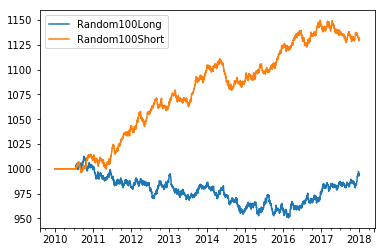

In [15]:
df_equity = rpt.series('equity')
df_equity.plot()

# Creating metastrategy
Create metastartegy that uses 'Random100Long' and 'Random100Short' accounts as underlying assets and rebalance the portfolio using these assets

In [16]:
#
# Important: beware of shorting synthetic assets, because costs can be incorrectly estimated 
#

class SimpleMetaStrategy(Strategy):
    name = "SimpleMetaStrategy"
    
    def calculate(self, asset: Asset) -> pd.DataFrame:
        """
        Calculates main logic of the strategy, this method must return pd.DataFrame or None (if asset is filtered at all)
        This information is used by portfolio composition stage
        """
        
        # Check if asset is greater MA200
        ohlc = asset.quotes()
                        
        ma200 =  ohlc['c'].rolling(200).mean()
        
        is_gt_ma200 = ohlc['c'] > ma200
        
        return pd.DataFrame({
            'is_gt_ma200': is_gt_ma200,
            'ma200': ma200,           
        })

    def compose_portfolio(self, date: datetime, account: Account, mf: MFrame) -> dict:
        """
        Returns a dictionary of portfolio composition at specific 'date'
        :param date: analysis date
        :param account: actual account at the previous date (see. Account class interface)
        :param mf: composite of metrics returned by self.calculate() method at 'date'

        :return: dictionary of  {asset_class_instance: float_opened_quantity, ... }

        -----------
        mf - cheat sheet
        -----------
        mf.assets - list of all assets
        mf.columns - list of all columns / metrics
        mf['metric_name'] - get metric 'metric_name' numpy array across all assets
        for asset, row in mf.items():  - iterate over all assets and rows, you can use row['metric_name'] too
        mf.get_at('asset_ticker', 'metric_name') - get scalar value of 'metric_name' for asset 'asset_ticker'
        mf.get_asset('asset_ticker') - get asset object by ticker name
        mf.get_filtered((mf['some_metric'] > 0) & (mf['another_metric'] == 1), sort_by_col='another_metric'[or None]) - get filtered and sorted data
        for (asset, m_data) in zip(*mf.get_filtered(_cond, sort_by_col='ma200')): - iterate over filtered and sorted results
        filtered_assets, filtere_data  = mf.get_filtered(..some condition..) - get filtered asset list and metrics
        mf.as_dataframe() - converts MFrame to Pandas.DataFrame. Warning: calculations might become much slower!
        """
        position = {}        
        flt_assets, flt_data = mf.get_filtered(mf['is_gt_ma200'] == 1)
        
        for asset in flt_assets:
            # Open long position on synthetic asset if its eqity is higher than 200 MA

            #
            # Important: beware of shorting synthetic assets, because costs can be incorrectly estimated 
            #
            position[asset] = 1.0
          
        return position

In [21]:
_acc_long_asset = acc_long.as_asset()
_acc_short_asset = acc_short.as_asset()

# Initialize backtester class for meta
metastrategy = SimpleMetaStrategy()
metaassets = [_acc_long_asset, _acc_short_asset]

meta_acc = Backtester.run(metastrategy,
                  metaassets, 
                  acc_initial_capital=10000,                  
                 )

## Meta account position

In [22]:
meta_acc.position()

{Asset<Random100Long>: Random100Long x 1.0}

# Meta backtesting report

In [23]:
rpt_meta = Report([meta_acc])

## Composite stats

In [24]:
rpt_meta.stats()

,SimpleMetaStrategy
Equity,10078.831942
CAGR %,0.098200
NetProfit $,78.831942
NetProfit %,0.788319
MaxDD $,-54.564411
MaxDD %,-0.541411
NumberOfTrades,114.000000
WinRate,0.456140
CAGR/MDD,0.181377
CapitalInvested (Avg),10000.000000


## Composite trades

In [26]:
rpt_meta.trades('SimpleMetaStrategy').tail()

,asset,date_entry,date_exit,side,n_transactions,wavg_price_entered,wavg_price_exited,qty_entered,qty_exited,pnl,costs
109,Random100Short,2017-10-19,2017-10-22,1,2,1128.801122,1130.314162,1.0,1.0,1.513040,-0.0
110,Random100Short,2017-12-05,2017-12-07,1,2,1136.930878,1136.880096,1.0,1.0,-0.050783,-0.0
111,Random100Short,2017-12-08,2017-12-10,1,2,1135.955540,1135.912414,1.0,1.0,-0.043126,-0.0
112,Random100Short,2017-12-13,2017-12-15,1,2,1134.884648,1134.874144,1.0,1.0,-0.010504,-0.0
113,Random100Long,2018-01-01,2018-01-01,1,1,NaN,NaN,1.0,0.0,0.000000,-0.0


## Composite equity

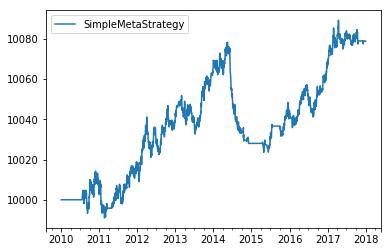

In [29]:
rpt_meta.series('equity').plot()